## Distributed Reverse Image Search and Retrieval

* This notebook will show you how you can use a convolutional neural network (convnet) to search through a large collection of images in a distributed (or parallel) environment. 
* Specifically, it will show you how you can retrieve a set of images which are similar to a query image. 
* Each worker will use a subset of your image dataset and return the approximate k nearest neighbors of the query image in terms of image content.

### Approximate Near Neighbour datastructures
* We will look at brute force search, and search using Approximate Near Neighbour datastructures.
* We will study how much Approximate Near Neighbour datastructures can help in a distributed setting
* Feel free to use any Approximate Near Neighbour library and algorithms you like (LSH, KDTree, etc), in the below code I will use pyflann

### Distributed / Parallel setting

* We will use RabbitMQ and celery with 4 workers
* Please write your code that it can indeed be used in a truly distributed setting, but for your submission and testing purposes it is enough if you just use one machine with four cores, and the cores will be your parallel workers. 
* Please use workers that have at least one GPU card, e.g. a p2.xlarge instance on AWS EC2.

### Installation and dependencies

The code has a number of dependencies, most of them can be installed with `pip`. You will need:

 * [rabbitMQ](https://www.rabbitmq.com/) I insalled this on our Amazon AMI. You can also install it yourself by following the instructions [here](https://www.rabbitmq.com/install-debian.html) 
 * [scikit-learn](scikit-learn.org)
 * [keras](https://keras.io)
 * [Pillow](https://python-pillow.org/)
 * [matplotlib](http://matplotlib.org)
 * [cPickle](https://docs.python.org/2/library/pickle.html) or Pickle
 * [tqdm] (https://github.com/tqdm/tqdm)
 * [celery](http://www.celeryproject.org/)
 * [pyflann](https://github.com/primetang/pyflann) (you can use any other near neighbour library you prefer or you can also write your own) that can create locality sensitive hashing, kdtrees, or other near neighbour datastructures.

### Prepare dataset

* Finally, prepare a folder of images to do the analysis on. 
* We will use the [Caltech-101 dataset](http://www.vision.caltech.edu/Image_Datasets/Caltech101/) containing roughly 9000 images in 101 categories. 
* If you want to check the scalability of your code, please feel free to use any other larger datasets, e.g. [ImageNet](http://www.image-net.org/)

* Create a ./data folder (mkdir data), and then uncomment the below lines to download the data and move it into a ./data folder


In [46]:
#!wget http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
#!tar -xvzf 101_ObjectCategories.tar.gz
#!mv ./101_ObjectCategories/ ./data/

### Import everything we will need

In [1]:
# We will use this for progress bars
!pip install tqdm

In [1]:
# We need to use python2 for this pip install to work. The standrard pip install for pyflann doesn't seem to work in Python3
#!pip install pyflann
from pyflann import *

In [2]:
#import six; from six.moves import cPickle as pickle
#import cPickle as pickle
import pickle


In [3]:
# we will use celery
!pip install celery

You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
# set up myguest user on rabbitmq

!sudo rabbitmqctl add_user myguest myguestpwd
!sudo rabbitmqctl set_permissions -p / myguest "." "." ".*"

Creating user "myguest" ...
Error: user_already_exists: myguest
Setting permissions for user "myguest" in vhost "/" ...


In [3]:
!sudo rabbitmqctl list_users

Listing users ...
guest	[administrator]
myguest	[]


In [4]:
%matplotlib inline
import os
import time
import random
import numpy as np
import matplotlib.pyplot
from matplotlib.pyplot import imshow
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model
from scipy.spatial import distance
from tqdm import tqdm

Using TensorFlow backend.


In [5]:
import json
from copy import deepcopy

from celery import group
from imagesearch_workers import upload_data, imagesearch_tasks, NumpyEncoder


### Preprocess the dataset with a trained VGG16 neural net 

We will load a previously-trained neural network, VGG16, which comes with Keras. If it's your first time loading it, it will automatically download the weights for you, which will take some time. Afterwards, the weights will be cached locally for future use. Keras has a number of other [pre-trained networs](https://keras.io/applications/) which you can try as well.

Once the network is loaded, we can take a look at the architecture of the network by running `model.summary()`.

In [6]:
model = keras.applications.VGG16(weights='imagenet', include_top=True)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

The summary gives us a layer-by-layer description of the network. Notice that VGG16 is a deep network with 13 convolutional layers. It was previously trained on millions of images, and has over 100,000,000 weights and biases, the majority of which connect to the first fully-connected layer (fc1). 

To see it in action, let's load an image and input it into the network. To help us do this, we will create a function `get_image(path)` which will handle the usual pre-processing steps: load an image from our file system and turn it into an input vector of the correct dimensions, those expected by VGG16, namely a color image of size 224x224.

In [15]:
# get_image will return a handle to the image itself, and a numpy array of its pixels to input the network
def get_image(path):
    img = image.load_img(path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [16]:
#!pip install Pillow

We load an image into memory, convert it into an input vector, and see the model's top 5 predictions for it.

In [17]:
#from IPython.display import display 
#from PIL import Image
import PIL.Image
from IPython.display import clear_output, Image, display, HTML

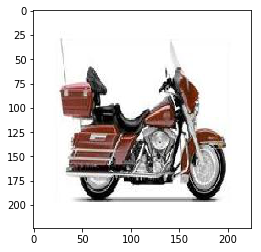

In [18]:
img, x = get_image("./data/101_ObjectCategories/Motorbikes/image_0003.jpg")
imshow(img)

### Let us check how VGG16 can be used for prediction

In [19]:
predictions = model.predict(x)
for pred in decode_predictions(predictions)[0]:
    print("predicted %s with probability %0.3f" % (pred[1], pred[2]))

predicted moped with probability 0.568
predicted motor_scooter with probability 0.342
predicted lawn_mower with probability 0.015
predicted disk_brake with probability 0.008
predicted harvester with probability 0.007


### Let us remove the top layer of VGG16

Now we will remove the top classification layer from our network, leaving the last fully-connected layer, "fc2 (Dense)" as the new output layer. The way we do this is by instantiating a new model called `feature_extractor` which takes a reference to the desired input and output layers in our VGG16 model. Thus, `feature_extractor`'s output is the layer just before the classification, the last 4096-neuron fully connected layer. 

Note about memory: although we instantiate a new object with most of the weights of our large model, it does not actually duplicate all the weights of the previous network into memory. 

If we run the `summary()` function again, we see that the architecture of `feat_extractor` is identical to the original `model`, except the last layer has been removed. We also know that not just the architecture is the same, but the two have the same weights as well.

In [20]:
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
feat_extractor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Now let's see the feature extractor in action. We pass the same image from before into it, and look at the results. The `predict` function returns an array with one element per image (in our case, there is just one). Each element contains a 4096-element array, which is the activations of the last fully-connected layer in VGG16. Let's plot the array as well.

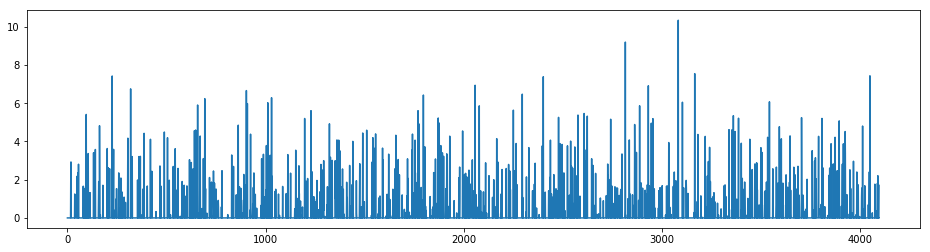

In [21]:
#img, x = get_image("./data/kitty.jpg")
img, x = get_image("./data/101_ObjectCategories/Motorbikes/image_0003.jpg")
feat = feat_extractor.predict(x)

matplotlib.pyplot.figure(figsize=(16,4))
matplotlib.pyplot.plot(feat[0])
matplotlib.pyplot.show()

Next, we will load all of the images in a directory, and use `feature_extractor` to get a feature vector for each one. If you have your own folder of images you want to analyze, change the path of `images_path` and it will search recursively through all the folders in it. Set `max_num_images` to cap it at some maximum number of images to load.

If you are using `101_ObjectCategories`, make sure you have followed the instructions above to download it, and make sure the path matches correctly.

In [22]:
images_path = './data/101_ObjectCategories'
max_num_images = 10000

images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
if max_num_images < len(images):
    images = [images[i] for i in sorted(random.sample(xrange(len(images)), max_num_images))]

print("keeping %d images to analyze" % len(images))

keeping 9144 images to analyze


In [23]:
#Let us shuffle the order of these images so later we will have random images in our training and query sets
images=np.random.permutation(images)

In [24]:
#Here are some examples:
images[1100:1105]

array(['./data/101_ObjectCategories/Faces_easy/image_0257.jpg',
       './data/101_ObjectCategories/Motorbikes/image_0032.jpg',
       './data/101_ObjectCategories/airplanes/image_0205.jpg',
       './data/101_ObjectCategories/electric_guitar/image_0010.jpg',
       './data/101_ObjectCategories/menorah/image_0051.jpg'], dtype='|S60')

The next part will take the longest. It might take about 5 minutes using a GPU. It might be about an hour if you only use CPU. We iterate through and extract the features from all the images in our `images` array, placing them into an array called `features`. 

In [25]:
# create a 'results' folder before running the below cell: mkdir results 

In [26]:
if 1: #set this to zero if you only did this calculation and just want to load it.
    features = []
    for image_path in tqdm(images):
        img, x = get_image(image_path);
        feat = feat_extractor.predict(x)[0]
        features.append(feat)
    pickle.dump([features,images], open('./results/high_dim_features_caltech101.pickle', 'wb'))
    #pickle.dump([features,images], open('./results/features_caltech101.pickle', 'wb'), protocol=2)
else:
    features,images = pickle.load(open('./results/high_dim_features_caltech101.pickle', 'rb'))

100%|██████████| 9144/9144 [04:17<00:00, 35.54it/s]


In [27]:
mydata= [{"features": np.array(feat), "path": path} for feat,path in zip(features,images)]

In [28]:
mydata[0:5]

[{'features': array([0.       , 0.3369267, 1.5789528, ..., 0.       , 0.       ,
         0.       ], dtype=float32),
  'path': './data/101_ObjectCategories/wrench/image_0006.jpg'},
 {'features': array([0.        , 0.        , 2.8525157 , ..., 0.39895922, 0.        ,
         0.        ], dtype=float32),
  'path': './data/101_ObjectCategories/minaret/image_0076.jpg'},
 {'features': array([0.4161087, 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ], dtype=float32),
  'path': './data/101_ObjectCategories/revolver/image_0006.jpg'},
 {'features': array([0.      , 1.139485, 0.      , ..., 0.      , 0.      , 0.      ],
        dtype=float32),
  'path': './data/101_ObjectCategories/Faces_easy/image_0097.jpg'},
 {'features': array([0.        , 0.21862862, 1.2695329 , ..., 2.6819594 , 0.        ,
         0.        ], dtype=float32),
  'path': './data/101_ObjectCategories/rooster/image_0029.jpg'}]

In [30]:
# Let us create train and test set. We will upload the train test to the workers, and the test set will be used for image queries

n_samples=9000

mydata_train=mydata[:n_samples]
mydata_test=mydata[n_samples:]
features=[]
images=[]
print(len(mydata_train))
print(len(mydata_test))


9000
144


In [31]:
# We will use four workers
n_workers = 4

In [39]:
# Let us split the train set to four parts. Each part will be uploaded to one of the four workers.
l = n_samples // n_workers
print(l)
mydata_to_workers=[]
mydata_to_workers = [mydata[i * l:(i + 1) * l] for i in range(n_workers)]
#mydata_to_workers.append(mydata[(n_workers - 1) * l:])


2250


In [40]:
for tmpdata in mydata_to_workers:
    print(len(tmpdata))

2250
2250
2250
2250


### Now it is time to upload the data to the workers. We will wait till the upload is done to all workers.

Run celery on the workers before running the cell bellow:

First set up your targets in your load balancers!!!
Then setup virtual environment on your workers: 
* source activate tensorflow_p27
Finall start celery on your workers:
* celery -A imagesearch_workers worker --loglevel=info
    

In [27]:
#let us upload the data
# This cell is missing, you will need to complete it
lazy_partials_upload = ...

### After the data set have been uploaded, and datastructures have been created on each workers, we can start submitting query images to the workers 

In [42]:
# select a query image from the test set
query_image_idx = int(len(mydata_test) * random.random())
#query_image_idx = 50
print(query_image_idx)

11


In [43]:
# This will be the feature vector we upload to the workers
query_feature=mydata_test[query_image_idx]['features']
print(query_feature.shape)

(4096,)


In [54]:
# this is where the upload happens
# This cell is missing, you will need to complete it
lazy_partials_upload = 

#### Display the query image

./data/101_ObjectCategories/airplanes/image_0153.jpg


Text(0.5,1,'Query image')

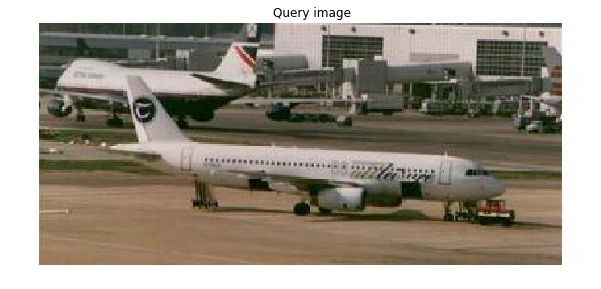

In [45]:

matplotlib.pyplot.figure(figsize = (10,8))
matplotlib.pyplot.axis('off')
query_path=mydata_test[query_image_idx]['path']
#query_path='./data/101_ObjectCategories/airplanes/image_0153.jpg'
print(query_path)

thumb_height=300
img = image.load_img(query_path)
img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
imshow(img)
matplotlib.pyplot.title('Query image')


#### Display the images returned by the workers. Make sure the workers a near neighbour data structure, e.g. kdtree or LSH

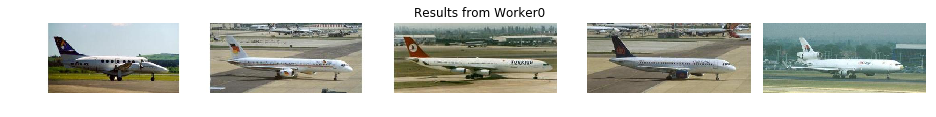

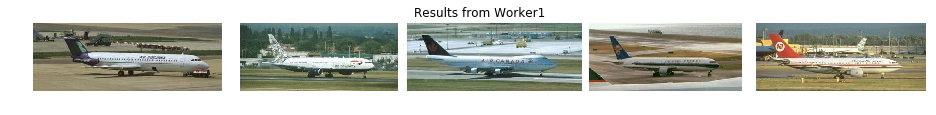

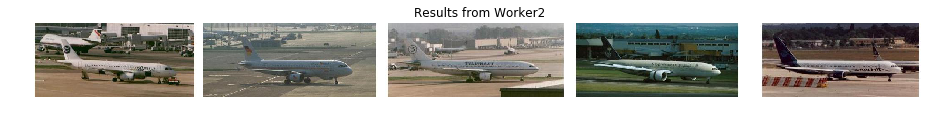

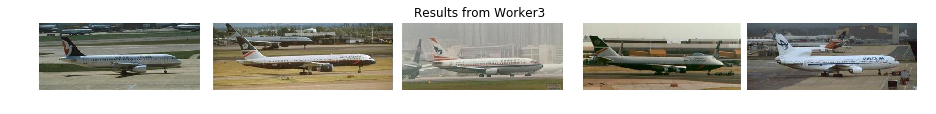

In [59]:
#show results    
# Code is missing you will need to complete it

#### Display the query times in seconds on each worker for the naive (brute force method), and the method using near neighbour data sturctures (e.g. kdtrees)

In [1]:
# Code is missing, you will need to complete it

worker0
('kdtree', 0.0002779960632324219)
('naive', 0.12339997291564941)
********
worker1
('kdtree', 0.0004119873046875)
('naive', 0.11877703666687012)
********
worker2
('kdtree', 0.0003490447998046875)
('naive', 0.1260819435119629)
********
worker3
('kdtree', 0.00037288665771484375)
('naive', 0.12200117111206055)
********